#Setup

In [ ]:
!apt-get install ffmpeg freeglut3-dev xvfb  # For visualization
!pip install "stable_baselines3==2.5.0"

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
freeglut3-dev is already the newest version (2.8.1-6).
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.13).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [ ]:
!pip install numpy==1.26.4

In [ ]:
import gymnasium as gym
import numpy as np
from gymnasium import spaces
#from stable_baselines3.common.env_checker import check_env


#Environment

In [ ]:
def seasonal_duck_curve(hour, season, noise_scale=0.03):
    """ Computes electricity demand based on seasonal duck curve """
    A = 400
    seasonal_params = {
        1: (100, 7, 80, 12, 120, 14, 250, 18, 30, 4),  # Summer
        2: (180, 6, 40, 12, 80, 14, 220, 17, 60, 4),  # Winter
        3: (130, 7, 90, 12, 100, 14, 180, 18, 40, 4)  # Spring/Autumn
    }
    B, t_morning, C, t_dip, D, mu_dip, E, t_evening, F, t_early = seasonal_params[season]
    demand = A + B / (1 + np.exp(-1 * (hour - t_morning))) - C / (1 + np.exp(-1 * (hour - t_dip))) - D * np.exp(-((hour - mu_dip)**2) / 4) + E / (1 + np.exp(-1 * (hour - t_evening)))
    return demand * random.uniform(0.9, 1.1)

def electricity_price_function(hour, season, demand, noise_scale=0.03):
    """ Computes electricity price based on seasonal demand """
    season_params = {
        1: (30, 15, 10),  # Summer
        2: (28, 14, 9),   # Winter
        3: (25, 12, 8)    # Spring/Autumn
    }
    A_q, B_q, C_q = season_params[season]
    base_price = A_q + B_q * np.cos(2 * np.pi * hour / 24) + C_q * np.cos(4 * np.pi * hour / 24)
    return max(base_price * random.uniform(0.9, 1.1), 0)


In [ ]:
import gymnasium as gym
import numpy as np
from gymnasium import spaces
import random

class ElectricityMarketEnv(gym.Env):
    """
    Custom Gym environment for an electricity market with battery storage.
    The agent decides when to charge/discharge to maximize profit.
    """
    def __init__(self, max_timesteps=365, degradation_rate=0.99):
        super(ElectricityMarketEnv, self).__init__()
        self.timestep = 0
        self.max_timesteps = max_timesteps
        self.season = self.get_season_from_timestep(0)  # Set initial season based on real months
        self.episode_count = 0  # Track training episodes
        self.degradation_rate = degradation_rate  # Battery degradation factor

        # Battery parameters
        self.initial_battery_capacity = 100  # Initial max storage capacity
        self.battery_capacity = self.initial_battery_capacity  # Maximum storage capacity
        self.battery_soc = 50  # Initial state of charge (SoC)
        self.efficiency = 0.95  # Charging/discharging efficiency

        # Electricity market parameters
        self.base_min_price, self.base_max_price = self._calculate_price_bounds()
        self.base_min_demand, self.base_max_demand = self._calculate_demand_bounds()

        self.min_price, self.max_price = self.base_min_price * 0.9, self.base_max_price * 1.1
        self.min_demand, self.max_demand = self.base_min_demand * 0.9, self.base_max_demand * 1.1


        # Action space: Charge (+) or discharge (-) within battery capacity
        self.action_space = spaces.Box(low=-self.battery_capacity, high=self.battery_capacity, shape=(1,), dtype=np.float32)

        # Observation space: [Battery SoC, Battery Capacity, Electricity Price, Demand, Hour, Season]
        self.observation_space = spaces.Box(
            low=np.array([0, 50, self.min_price, self.min_demand, 0, 1], dtype=np.float32),
            high=np.array([self.initial_battery_capacity, self.initial_battery_capacity, self.max_price, self.max_demand, 23, 3], dtype=np.float32),
            dtype=np.float32
        )

        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.battery_capacity = self.initial_battery_capacity  # Reset battery capacity
        self.timestep = 0
        self.battery_soc = 50  # Reset battery SoC
        self.season = self.get_season_from_timestep(self.timestep)  # Set season dynamically
        self.episode_count += 1  # Track episode count
        return self._get_state(), {}

    def step(self, action):
        """
        Executes one step in the environment.
        Action: Charge (>0) or discharge (<0) electricity.
        """
        self.timestep += 1
        self.season = self.get_season_from_timestep(self.timestep)
        done = self.timestep >= self.max_timesteps or self.battery_soc <= 0

        self.battery_capacity *= self.degradation_rate
        self.battery_capacity = max(self.battery_capacity, 50)  # Minimum capacity limit

        # Get new price and demand based on season
        hour = self.timestep % 24
        demand = seasonal_duck_curve(hour, self.season)
        price = electricity_price_function(hour, self.season, demand)

        # Clip action to valid range (-battery_capacity, +battery_capacity)
        action = np.clip(action[0], -self.battery_capacity, self.battery_capacity)

        # Charge/discharge the battery
        if action > 0:  # Charging (cost money)
            charge_amount = min(action, self.battery_capacity - self.battery_soc)
            cost = charge_amount * price / self.efficiency
            self.battery_soc += charge_amount * self.efficiency
            reward = -cost  # Negative reward for spending money
            #print(f"Step {self.timestep}, Season: {self.get_season_name(self.season)}: Charging {charge_amount:.2f} units at price {price:.2f}. Cost: {cost:.2f}. SoC: {self.battery_soc:.2f}.")
        else:  # Discharging (sell to market)
            discharge_amount = min(-action, self.battery_soc, demand)
            revenue = discharge_amount * price * self.efficiency
            self.battery_soc -= discharge_amount / self.efficiency
            reward = revenue  # Positive reward for selling
            #print(f"Step {self.timestep}, Season: {self.get_season_name(self.season)}: Discharging {discharge_amount:.2f} units at price {price:.2f}. Revenue: {revenue:.2f}. SoC: {self.battery_soc:.2f}.")

        next_state = np.array([self.battery_soc, self.battery_capacity, price, demand, hour, self.season], dtype=np.float32)
        return next_state, reward, done, False, {}

    def _get_state(self):
        """ Returns the current state: [SoC, Price, Demand, Hour, Season] """
        hour = self.timestep % 24
        demand = seasonal_duck_curve(hour, self.season)
        price = electricity_price_function(hour, self.season, demand)
        #print(f"State - SoC: {self.battery_soc:.2f}, Price: {price:.2f}, Demand: {demand:.2f}, Hour: {hour}, Season: {self.season}.")
        return np.array([self.battery_soc, self.battery_capacity, price, demand, hour, self.season], dtype=np.float32)



    def get_season_from_timestep(self, timestep):
        """ Determines season based on day of the year """
        month = (timestep // 30) % 12  # Approximate month from timestep
        if month in [11, 0, 1]:
            return 2  # Winter
        elif month in [5, 6, 7]:
            return 1  # Summer
        else:
            return 3  # Spring/Autumn

    def get_season_name(self, season):
        return {1: "Summer", 2: "Winter", 3: "Spring/Autumn"}.get(season, "Unknown")


    def evaluate_agent(self, agent, num_episodes=3):
        """ Evaluates the agent over multiple episodes and prints performance metrics per season. """
        total_rewards = []
        season_rewards = {1: [], 2: [], 3: []}

        for ep in range(num_episodes):
            state, _ = self.reset()
            done = False
            episode_reward = 0
            seasonal_reward = {1: 0, 2: 0, 3: 0}

            while not done:
                action, _ = agent.predict(state)
                state, reward, done, _, _ = self.step(action)
                episode_reward += reward
                seasonal_reward[self.season] += reward

            total_rewards.append(episode_reward)
            for season in seasonal_reward:
                season_rewards[season].append(seasonal_reward[season])

            print(f"Episode {ep + 1}: Total Reward = {episode_reward:.2f}")

        avg_reward = np.mean(total_rewards)
        avg_seasonal_rewards = {season: np.mean(rewards) if rewards else 0 for season, rewards in season_rewards.items()}

        print(f"\nEvaluation Results:")
        print(f"Average Reward over {num_episodes} episodes: {avg_reward:.2f}")
        print(f"Seasonal Performance:")
        for season, avg in avg_seasonal_rewards.items():
            print(f"  {self.get_season_name(season)}: {avg:.2f}")

        return avg_reward, avg_seasonal_rewards

    def _calculate_price_bounds(self):
        """ Determine min/max price dynamically based on electricity_price_function """
        min_price = float('inf')
        max_price = float('-inf')
        for season in [1, 2, 3]:
            for hour in range(24):
                demand = seasonal_duck_curve(hour, season)
                price = electricity_price_function(hour, season, demand)
                min_price = min(min_price, price)
                max_price = max(max_price, price)
        return min_price, max_price

    def _calculate_demand_bounds(self):
        """ Determine min/max demand dynamically based on seasonal_duck_curve """
        min_demand = float('inf')
        max_demand = float('-inf')
        for season in [1, 2, 3]:
            for hour in range(24):
                demand = seasonal_duck_curve(hour, season)
                min_demand = min(min_demand, demand)
                max_demand = max(max_demand, demand)
        return min_demand, max_demand



In [ ]:
import gymnasium as gym
import numpy as np
from gymnasium import spaces
import random

class ElectricityMarketEnvSeason(gym.Env):
    """
    Custom Gym environment for an electricity market with battery storage.
    The agent decides when to charge/discharge to maximize profit.
    """
    def __init__(self, max_timesteps=365, degradation_rate=0.99, season = None):
        super(ElectricityMarketEnvSeason, self).__init__()
        self.timestep = 0
        self.max_timesteps = max_timesteps
        self.one_season = season
        if self.one_season is not None:
          self.season = self.one_season
        else:
          self.season = self.get_season_from_timestep(0)  # Set initial season based on real months
        self.episode_count = 0  # Track training episodes
        self.degradation_rate = degradation_rate  # Battery degradation factor

        # Battery parameters
        self.initial_battery_capacity = 100  # Initial max storage capacity
        self.battery_capacity = self.initial_battery_capacity  # Maximum storage capacity
        self.battery_soc = 50  # Initial state of charge (SoC)
        self.efficiency = 0.95  # Charging/discharging efficiency

        # Electricity market parameters
        self.base_min_price, self.base_max_price = self._calculate_price_bounds()
        self.base_min_demand, self.base_max_demand = self._calculate_demand_bounds()

        self.min_price, self.max_price = self.base_min_price * 0.9, self.base_max_price * 1.1
        self.min_demand, self.max_demand = self.base_min_demand * 0.9, self.base_max_demand * 1.1


        # Action space: Charge (+) or discharge (-) within battery capacity
        self.action_space = spaces.Box(low=-self.battery_capacity, high=self.battery_capacity, shape=(1,), dtype=np.float32)

        # Observation space: [Battery SoC, Battery Capacity, Electricity Price, Demand, Hour, Season]
        self.observation_space = spaces.Box(
            low=np.array([0, 50, self.min_price, self.min_demand, 0, 1], dtype=np.float32),
            high=np.array([self.initial_battery_capacity, self.initial_battery_capacity, self.max_price, self.max_demand, 23, 3], dtype=np.float32),
            dtype=np.float32
        )

        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.battery_capacity = self.initial_battery_capacity  # Reset battery capacity
        self.timestep = 0
        self.battery_soc = 50  # Reset battery SoC
        if self.one_season is not None:
          self.season = self.one_season
        else:
          self.season = self.get_season_from_timestep(0)   # Set season dynamically
        self.episode_count += 1  # Track episode count
        return self._get_state(), {}

    def step(self, action):
        """
        Executes one step in the environment.
        Action: Charge (>0) or discharge (<0) electricity.
        """
        self.timestep += 1
        if self.one_season is None:
          self.season = self.get_season_from_timestep(0)
        done = self.timestep >= self.max_timesteps or self.battery_soc <= 0

        self.battery_capacity *= self.degradation_rate
        self.battery_capacity = max(self.battery_capacity, 50)  # Minimum capacity limit

        # Get new price and demand based on season
        hour = self.timestep % 24
        demand = seasonal_duck_curve(hour, self.season)
        price = electricity_price_function(hour, self.season, demand)

        # Clip action to valid range (-battery_capacity, +battery_capacity)
        action = np.clip(action[0], -self.battery_capacity, self.battery_capacity)

        # Charge/discharge the battery
        if action > 0:  # Charging (cost money)
            charge_amount = min(action, self.battery_capacity - self.battery_soc)
            cost = charge_amount * price / self.efficiency
            self.battery_soc += charge_amount * self.efficiency
            reward = -cost  # Negative reward for spending money
            #print(f"Step {self.timestep}, Season: {self.get_season_name(self.season)}: Charging {charge_amount:.2f} units at price {price:.2f}. Cost: {cost:.2f}. SoC: {self.battery_soc:.2f}.")
        else:  # Discharging (sell to market)
            discharge_amount = min(-action, self.battery_soc, demand)
            revenue = discharge_amount * price * self.efficiency
            self.battery_soc -= discharge_amount / self.efficiency
            reward = revenue  # Positive reward for selling
            #print(f"Step {self.timestep}, Season: {self.get_season_name(self.season)}: Discharging {discharge_amount:.2f} units at price {price:.2f}. Revenue: {revenue:.2f}. SoC: {self.battery_soc:.2f}.")

        next_state = np.array([self.battery_soc, self.battery_capacity, price, demand, hour, self.season], dtype=np.float32)
        return next_state, reward, done, False, {}

    def _get_state(self):
        """ Returns the current state: [SoC, Price, Demand, Hour, Season] """
        hour = self.timestep % 24
        demand = seasonal_duck_curve(hour, self.season)
        price = electricity_price_function(hour, self.season, demand)
        #print(f"State - SoC: {self.battery_soc:.2f}, Price: {price:.2f}, Demand: {demand:.2f}, Hour: {hour}, Season: {self.season}.")
        return np.array([self.battery_soc, self.battery_capacity, price, demand, hour, self.season], dtype=np.float32)



    def get_season_from_timestep(self, timestep):
        """ Determines season based on day of the year """
        month = (timestep // 30) % 12  # Approximate month from timestep
        if month in [11, 0, 1]:
            return 2  # Winter
        elif month in [5, 6, 7]:
            return 1  # Summer
        else:
            return 3  # Spring/Autumn

    def get_season_name(self, season):
        return {1: "Summer", 2: "Winter", 3: "Spring/Autumn"}.get(season, "Unknown")


    def evaluate_agent(self, agent, num_episodes=3):
        """ Evaluates the agent over multiple episodes and prints performance metrics per season. """
        total_rewards = []
        season_rewards = {1: [], 2: [], 3: []}

        for ep in range(num_episodes):
            state, _ = self.reset()
            done = False
            episode_reward = 0
            seasonal_reward = {1: 0, 2: 0, 3: 0}

            while not done:
                action, _ = agent.predict(state)
                state, reward, done, _, _ = self.step(action)
                episode_reward += reward
                seasonal_reward[self.season] += reward

            total_rewards.append(episode_reward)
            for season in seasonal_reward:
                season_rewards[season].append(seasonal_reward[season])

            print(f"Episode {ep + 1}: Total Reward = {episode_reward:.2f}")

        avg_reward = np.mean(total_rewards)
        avg_seasonal_rewards = {season: np.mean(rewards) if rewards else 0 for season, rewards in season_rewards.items()}

        print(f"\nEvaluation Results:")
        print(f"Average Reward over {num_episodes} episodes: {avg_reward:.2f}")
        print(f"Seasonal Performance:")
        for season, avg in avg_seasonal_rewards.items():
            print(f"  {self.get_season_name(season)}: {avg:.2f}")

        return avg_reward, avg_seasonal_rewards

    def _calculate_price_bounds(self):
        """ Determine min/max price dynamically based on electricity_price_function """
        min_price = float('inf')
        max_price = float('-inf')
        for season in [1, 2, 3]:
            for hour in range(24):
                demand = seasonal_duck_curve(hour, season)
                price = electricity_price_function(hour, season, demand)
                min_price = min(min_price, price)
                max_price = max(max_price, price)
        return min_price, max_price

    def _calculate_demand_bounds(self):
        """ Determine min/max demand dynamically based on seasonal_duck_curve """
        min_demand = float('inf')
        max_demand = float('-inf')
        for season in [1, 2, 3]:
            for hour in range(24):
                demand = seasonal_duck_curve(hour, season)
                min_demand = min(min_demand, demand)
                max_demand = max(max_demand, demand)
        return min_demand, max_demand



In [ ]:
summer_env = ElectricityMarketEnvSeason(season=1, max_timesteps=365)
winter_env = ElectricityMarketEnvSeason(season=2, max_timesteps=365)
spring_env = ElectricityMarketEnvSeason(season=3, max_timesteps=365)

In [ ]:
env = ElectricityMarketEnv()
obs, _ = env.reset()



# Evaluation on first type of results

In [ ]:
!pip install absl-py==2.1.0 astunparse==1.6.3 certifi==2025.1.31 charset-normalizer==3.4.1 cloudpickle==3.1.1 contourpy==1.3.1 cycler==0.12.1 Farama-Notifications==0.0.4 filelock==3.17.0 flatbuffers==25.2.10 fonttools==4.56.0 fsspec==2025.2.0 gast==0.6.0 google-pasta==0.2.0 grpcio==1.70.0 gymnasium==1.0.0 h5py==3.13.0 idna==3.10 Jinja2==3.1.5 keras==3.8.0 kiwisolver==1.4.8 libclang==18.1.1 Markdown==3.7 markdown-it-py==3.0.0 MarkupSafe==3.0.2 matplotlib==3.10.0 mdurl==0.1.2 ml-dtypes==0.4.1 mpmath==1.3.0 namex==0.0.8 networkx==3.4.2 numpy==2.0.2 opt_einsum==3.4.0 optree==0.14.0 packaging==24.2 pandas==2.2.3 pillow==11.1.0 pip==23.2.1 protobuf==5.29.3 Pygments==2.19.1 pyparsing==3.2.1 python-dateutil==2.9.0.post0 pytz==2025.1 requests==2.32.3 rich==13.9.4 setuptools==75.8.1 six==1.17.0 stable_baselines3==2.5.0 sympy==1.13.1 tensorboard==2.18.0 tensorboard-data-server==0.7.2 tensorflow==2.18.0 tensorflow_intel==2.18.0 termcolor==2.5.0 torch==2.6.0 typing_extensions==4.12.2 tzdata==2025.1 urllib3==2.3.0 Werkzeug==3.1.3 wheel==0.45.1 wrapt==1.17.2


  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached fsspec-2025.2.0-py3-none-any.whl.metadata (11 kB)
  Using cached h5py-3.13.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.5 kB)
  Using cached numpy-2.0.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached pandas-2.2.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (89 kB)
  Using cached pip-23.2.1-py3-none-any.whl.metadata (4.2 kB)
  Using cached protobuf-5.29.3-cp38-abi3-manylinux2014_x86_64.whl.metadata (592 bytes)
  Using cached pygments-2.19.1-py3-none-any.whl.metadata (2.5 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached setuptools-75.8.1-py3-none-any.whl.metadata (6.7 kB)
ERROR: Ignored the following versions that require a different python version: 1.21.2 Requires-Python >=3.7,<3.11; 1.21.3 Requires-Python >=3.7,<3.11; 1.21.4 Requires-Python >=3.7,<3.11; 1.21.5 Re

In [ ]:
!pip install --upgrade cloudpickle numpy

In [ ]:
!pip install torch==2.6.0

We will evaulate each alogrithm on 100 episodes as described in paper:


"**We investigate statistical variations in the few-run regime by evaluating 100 independent runs for
each algorithm, where the score for a run is the average returns obtained in 100 evaluation episodes**
taking place after training. Each run corresponds to training one algorithm on each of the 26 games
in Atari 100k. This provides us with 26 × 100 scores per algorithm, which we then subsample with
replacement to 3–100 runs. The subsampled scores are then used to produce a collection of point
estimates whose statistical variability can be measured. We begin by using this experimental protocol
to highlight statistical concerns regarding median normalized scores"

In [ ]:
from stable_baselines3 import DDPG, PPO, TD3
import os
import glob

In [ ]:
results = { "DDPG" :[], "PPO" :[], "TD3" :[]}
models_dir = "./"
reward =0
files = glob.glob(models_dir + "/*.zip")
for model_path in files:
  if "DDPG" in model_path:
    model_type = "DDPG"
    ddpg = DDPG("MlpPolicy", env, verbose=0)
    ddpg_model = DDPG.load(model_path, env=env, custom_objects={'observation_space': ddpg.observation_space, 'action_space': ddpg.action_space})
    reward, _ = env.evaluate_agent(ddpg_model, num_episodes=100)
  elif "PPO" in model_path:
    model_type = "PPO"
    ppo = PPO("MlpPolicy", env, verbose=0)
    ppo_model = PPO.load(model_path, env=env, custom_objects={'observation_space': ppo.observation_space, 'action_space': ppo.action_space})
    reward, _ = env.evaluate_agent(ppo_model, num_episodes=100)
  elif "TD3" in model_path:
    model_type = "TD3"
    td3 = TD3("MlpPolicy", env, verbose=0)
    td3_model = TD3.load(model_path, env=env, custom_objects={'observation_space': td3.observation_space, 'action_space': td3.action_space})
    reward, _ = env.evaluate_agent(td3_model, num_episodes=100)
  print(f"Model: {model_type}, Reward: {reward}")
  results[model_type].append(reward)

Episode 1: Total Reward = 2166.36
Episode 2: Total Reward = 2342.29
Episode 3: Total Reward = 2090.76
Episode 4: Total Reward = 2434.70
Episode 5: Total Reward = 2042.92
Episode 6: Total Reward = 2301.13
Episode 7: Total Reward = 2015.61
Episode 8: Total Reward = 2235.59
Episode 9: Total Reward = 2212.72
Episode 10: Total Reward = 2398.58
Episode 11: Total Reward = 2278.31
Episode 12: Total Reward = 2167.83
Episode 13: Total Reward = 2239.86
Episode 14: Total Reward = 2389.85
Episode 15: Total Reward = 2056.43
Episode 16: Total Reward = 2208.55
Episode 17: Total Reward = 2164.92
Episode 18: Total Reward = 2323.99
Episode 19: Total Reward = 2175.66
Episode 20: Total Reward = 2293.40
Episode 21: Total Reward = 2114.19
Episode 22: Total Reward = 2371.10
Episode 23: Total Reward = 2358.05
Episode 24: Total Reward = 2389.63
Episode 25: Total Reward = 2180.96
Episode 26: Total Reward = 2358.52
Episode 27: Total Reward = 2279.34
Episode 28: Total Reward = 2123.11
Episode 29: Total Reward = 21

In [ ]:
results["PPO_16_Ensamble"] = [8014.48,
  8048.22,
  8022.46,
  8015.92,
  7973.09,
  7915.11,
  7959.08,
  7981.2,
  5718.75,
  7987.32]

In [ ]:
results

{'DDPG': [np.float64(2220.1950429237686),
  np.float64(2218.1200907788566),
  np.float64(2211.4345407757223),
  np.float64(2237.487907707961),
  np.float64(-1231.7822116966197),
  np.float64(2237.487907707961)],
 'PPO': [np.float64(4886.989625205073),
  np.float64(4194.451471769973),
  np.float64(5996.400563959302),
  np.float64(6121.9096402378855),
  np.float64(6121.9096402378855),
  np.float64(7579.46426103944)],
 'TD3': [np.float64(-1231.7822116966197),
  np.float64(2237.487907707961),
  np.float64(-1214.9900595437514),
  np.float64(-1190.3659000298894),
  np.float64(2211.4345407757223)],
 'PPO_16_Ensamble': [8014.48,
  8048.22,
  8022.46,
  8015.92,
  7973.09,
  7915.11,
  7959.08,
  7981.2,
  5718.75,
  7987.32]}

In [ ]:
results_reformated

{'DDPG': array([[ 2220.19504292,  2218.12009078,  2211.43454078,  2237.48790771,
         -1231.7822117 ,  2237.48790771]]),
 'PPO': array([[4886.98962521, 4194.45147177, 5996.40056396, 6121.90964024,
         6121.90964024, 7579.46426104]]),
 'TD3': array([[-1231.7822117 ,  2237.48790771, -1214.99005954, -1190.36590003,
          2211.43454078]]),
 'PPO_16_Ensamble': array([[8014.48, 8048.22, 8022.46, 8015.92, 7973.09, 7915.11, 7959.08,
         7981.2 , 5718.75, 7987.32]])}

In [ ]:
!pip install git+https://github.com/google-research/rliable

  Cloning https://github.com/google-research/rliable to /tmp/pip-req-build-stl9_zoq
  Running command git clone --filter=blob:none --quiet https://github.com/google-research/rliable /tmp/pip-req-build-stl9_zoq
  Resolved https://github.com/google-research/rliable to commit 3ccd9f4dea577a04d3d2b557f259aac08badbd81
  Preparing metadata (setup.py) ... done


In [ ]:
from rliable import library as rly
from rliable import metrics
from rliable import plot_utils

In [ ]:
results_reformated = {key: np.array([[val_] for val_ in val]) for key, val in results.items() }

In [ ]:
results_reformated

{'DDPG': array([[ 2220.19504292],
        [ 2218.12009078],
        [ 2211.43454078],
        [ 2237.48790771],
        [-1231.7822117 ],
        [ 2237.48790771]]),
 'PPO': array([[4886.98962521],
        [4194.45147177],
        [5996.40056396],
        [6121.90964024],
        [6121.90964024],
        [7579.46426104]]),
 'TD3': array([[-1231.7822117 ],
        [ 2237.48790771],
        [-1214.99005954],
        [-1190.36590003],
        [ 2211.43454078]]),
 'PPO_16_Ensamble': array([[8014.48],
        [8048.22],
        [8022.46],
        [8015.92],
        [7973.09],
        [7915.11],
        [7959.08],
        [7981.2 ],
        [5718.75],
        [7987.32]])}

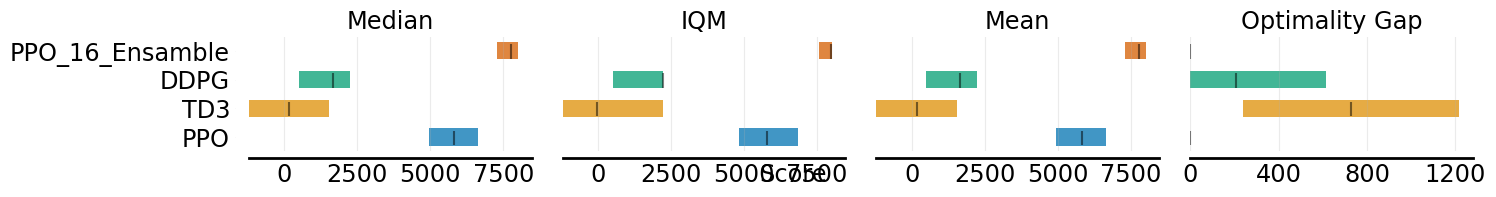

In [ ]:
algorithms = ['PPO', 'TD3', 'DDPG', 'PPO_16_Ensamble']
# Load ALE scores as a dictionary mapping algorithms to their human normalized
# score matrices, each of which is of size `(num_runs x num_games)`.
atari_200m_normalized_score_dict = results_reformated
aggregate_func = lambda x: np.array([
  metrics.aggregate_median(x),
  metrics.aggregate_iqm(x),
  metrics.aggregate_mean(x),
  metrics.aggregate_optimality_gap(x)])
aggregate_scores, aggregate_score_cis = rly.get_interval_estimates(
  atari_200m_normalized_score_dict, aggregate_func, reps=50000)
fig, axes = plot_utils.plot_interval_estimates(
  aggregate_scores, aggregate_score_cis,
  metric_names=['Median', 'IQM', 'Mean', 'Optimality Gap'],
  algorithms=algorithms, xlabel='Score')

In [ ]:
results_reformated = {key: np.array([val]) for key, val in results.items() }

<Axes: xlabel='Score $(\\tau)$', ylabel='Fraction of runs with score $> \\tau$'>

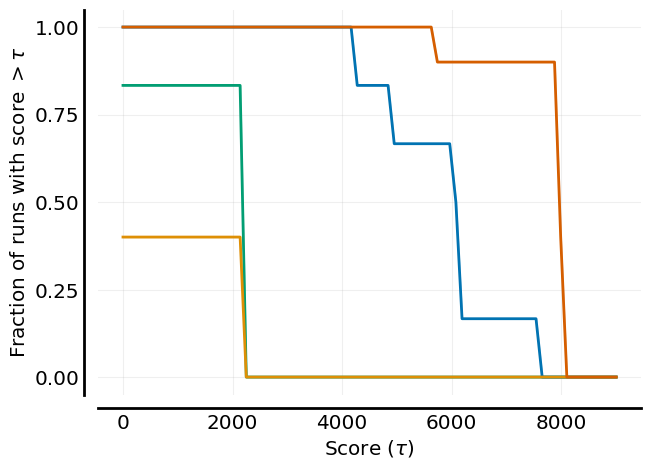

In [ ]:
# Load ALE scores as a dictionary mapping algorithms to their human normalized
# score matrices, each of which is of size `(num_runs x num_games)`.
atari_200m_normalized_score_dict = results_reformated
# Human normalized score thresholds
atari_200m_thresholds = np.linspace(0.0, 9000, 81)
score_distributions, score_distributions_cis = rly.create_performance_profile(
    atari_200m_normalized_score_dict, atari_200m_thresholds)
# Plot score distributions
fig, ax = plt.subplots(ncols=1, figsize=(7, 5))
plot_utils.plot_performance_profiles(
  score_distributions, atari_200m_thresholds,
  performance_profile_cis=score_distributions_cis,
  colors=dict(zip(algorithms, sns.color_palette('colorblind'))),
  xlabel=r'Score $(\tau)$',
  ax=ax)
